# ESAME DI TECNICHE DI RAPPRESENTAZIONE E MODELLIZZAZIONE DEI DATI

## Studio del profilo di densità NFW e stima della massa e della concentrazione di aloni di materia oscura

Il progetto ha lo scopo di stimare i parametri fisici degli aloni di materia oscura (massa e concentrazione) a partire da simulazioni cosmologiche. Il metodo si basa sulla modellizzazione analitica del profilo di densità proiettato (NFW), l'analisi statistica dei dati simulati e l'uso di tecniche di inferenza bayesiana tramite MCMC (`emcee`).

Il codice è strutturato in **quattro parti**:
1. **Modello analitico del profilo NFW (2D)**
2. **Analisi dei dati simulati con binning per ricchezza**
3. **Stima dei parametri con campionamento MCMC**
4. **Valutazione dei risultati: fit, intervalli di confidenza, $\chi^2$**


## PARTE A: Modello Analitico 2D del Profilo NFW

In questa sezione si definisce un modello teorico del profilo di densità proiettato degli aloni secondo la formulazione NFW.  
Vengono costruite diverse funzioni per calcolare i parametri caratteristici (raggio di scala $r_s$, densità caratteristica $\rho_s$) necessari per implementare la funzione $\Sigma(R,M,c,z)$.

Si producono dei grafici che mostrano il comportamento del profilo $\Sigma$ al variare della massa totale dell'alone e della concentrazione.


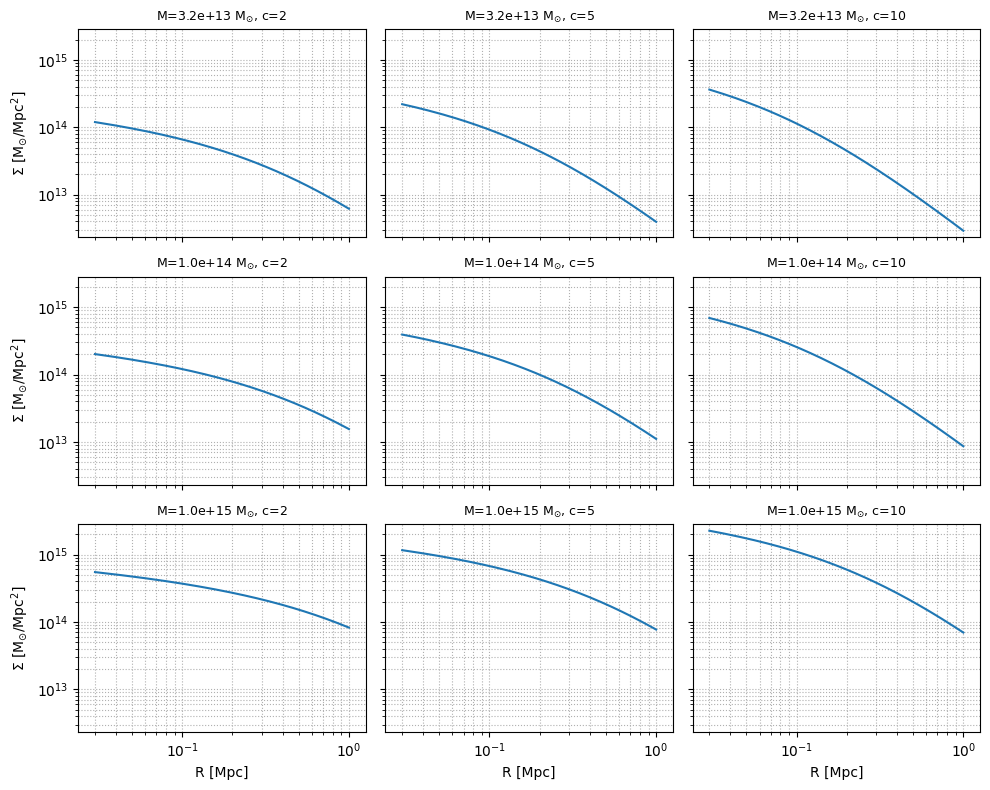

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import emcee
import corner
import pandas as pd

RU = 0.286 * 0.7**2 * 2.7751428946e11
#definzione funzioni per costruire profilo di densità
def compute_rs(M, c, z=0.0):
    rhom = RU * (1 + z)**3
    return (3 * M / (4 * np.pi * 200 * rhom))**(1/3) / c

def compute_rhos(M, c, z=0.0):
    fc = np.log(1 + c) - c/(1 + c)
    delta_char = 200 * c**3 / (3 * fc)
    rhom = RU * (1 + z)**3
    return rhom * delta_char

def proj_nfw_sigma(R, M, c, z=0.0):
    rs   = compute_rs(M, c, z)
    rhos = compute_rhos(M, c, z)
    x = R / rs

    y = np.zeros_like(x)
    m1, m2, m3 = x < 1, x == 1, x > 1
    y[m1] = (1/(x[m1]**2 - 1) *(1 - 2/np.sqrt(1 - x[m1]**2) * np.arctanh(np.sqrt((1 - x[m1])/(1 + x[m1])))))
    y[m2] = 1/3
    y[m3] = (1/(x[m3]**2 - 1) *(1 - 2/np.sqrt(x[m3]**2 - 1) * np.arctan(np.sqrt((x[m3] - 1)/(x[m3] + 1)))))
    return 2 * rs * rhos * y

# Parametri
M_vals = [10**13.5, 10**14, 10**15]
c_vals = [2, 5, 10]
R_ana  = np.linspace(0.03, 1.0, 300)


all_sigmas = [proj_nfw_sigma(R_ana, M, c) for M in M_vals for c in c_vals]
ymin, ymax = min(s.min() for s in all_sigmas), max(s.max() for s in all_sigmas)
xmin, xmax = R_ana.min(), R_ana.max()

# scalo la grandezza dei grafici per far in modo di vedere tutti i punti
pad_frac = 0.1
x_plot_min = xmin * 10**(-pad_frac)
x_plot_max = xmax * 10**( pad_frac)
y_plot_min = ymin * 10**(-pad_frac)
y_plot_max = ymax * 10**( pad_frac)
#plot dei primi 9 grafici
fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharex=True, sharey=True)
for i, M in enumerate(M_vals):
    for j, c in enumerate(c_vals):
        Σ = proj_nfw_sigma(R_ana, M, c)
        ax = axes[i, j]
        ax.loglog(R_ana, Σ, lw=1.5)
        
        ax.set_title(f"M={M:.1e} M$_⊙$, c={c}", fontsize=9)
        ax.grid(True, which='both', ls=':')
        ax.set_xlim(x_plot_min, x_plot_max)
        ax.set_ylim(y_plot_min, y_plot_max)
        if i == 2: ax.set_xlabel("R [Mpc]")
        if j == 0: ax.set_ylabel("Σ [M$_⊙$/Mpc$^2$]")


fig.tight_layout()

## PARTE B: Dati Simulati, Binning e Analisi Statistica

In questa parte si caricano i dati provenienti da simulazioni cosmologiche (`halo_catalog.fit`) e si suddividono gli aloni in 5 gruppi (bin) in base alla loro ricchezza (`λ`, direttamente correlata alla massa totale dell'alone).  
Per ciascun gruppo si calcola il profilo medio di densità proiettata `Σ(R)` e la sua deviazione standard.  
I risultati vengono rappresentati con barre di errore.


Numero di aloni per bin: [10185, 13131, 5791, 1565, 1018]


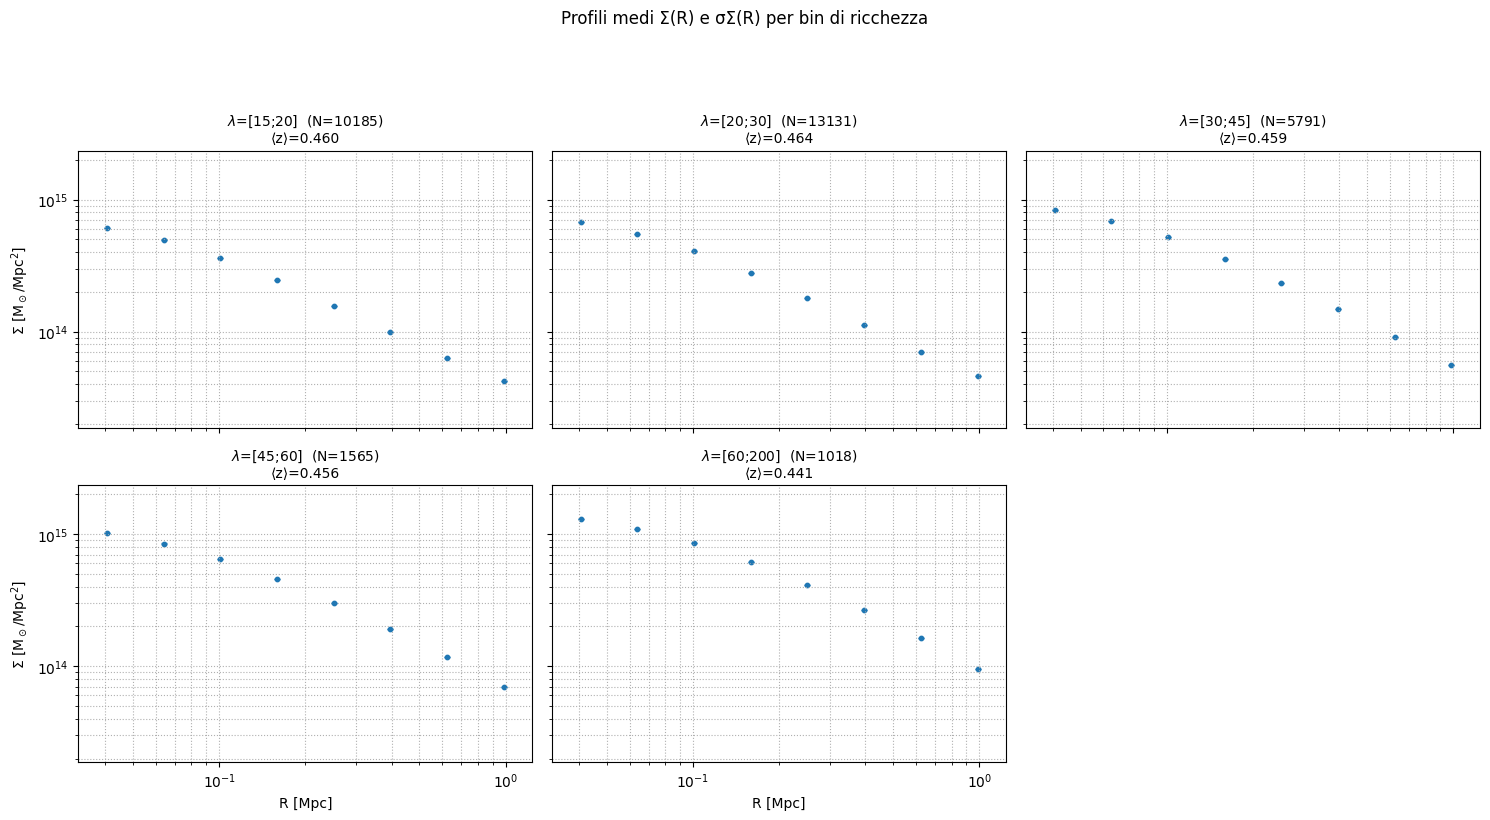

In [65]:

#  carico i dati 
tbl   = Table.read("halo_catalog.fit")
R     = np.load("R_values.npy")
z     = np.array(tbl["Z"])
rich  = np.array(tbl["LAMBDA_TR"])
sigma = np.array(tbl["SIGMA_of_R"])

# definisco i bin di ricchezza 
lambda_edges = [15, 20, 30, 45, 60, 200]
n_bins       = len(lambda_edges) - 1

# array dove accumulo i risultati 
mean_z      = []
std_z       = []
mean_sigmas = []
std_sigmas  = []
halo_counts = []         

for i in range(n_bins):
    low, high = lambda_edges[i], lambda_edges[i+1]
    mask = (rich >= low) & (rich < high) if i < n_bins-1 else (rich >= low) & (rich <= high)

    N_halo = mask.sum()           
    halo_counts.append(N_halo)    

    profs = sigma[mask]
    mean_z.append(np.mean(z[mask]))
    std_z.append(np.std(z[mask]))
    mean_sigmas.append(np.mean(profs, axis=0))
    std_sigmas.append(np.std(profs, axis=0))


print("Numero di aloni per bin:", halo_counts)

# limiti per gli assi, identici tra i pannelli
all_lower = [m - s for m, s in zip(mean_sigmas, std_sigmas)]
all_upper = [m + s for m, s in zip(mean_sigmas, std_sigmas)]
ymin, ymax = min(np.min(a) for a in all_lower), max(np.max(a) for a in all_upper)
xmin, xmax = R.min(), R.max()
pad_frac = 0.1
x_lo, x_hi = xmin * 10**(-pad_frac), xmax * 10**(pad_frac)
y_lo, y_hi = ymin * 10**(-pad_frac), ymax * 10**(pad_frac)


fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(n_bins):
    ax   = axes[i]
    μ, σ = mean_sigmas[i], std_sigmas[i]/halo_counts[i]
    zbar = mean_z[i]

    ax.scatter(R, μ, s=10, color='C0')
    ax.errorbar(R, μ, yerr=σ, fmt='none', ecolor='C0', elinewidth=1, capsize=2, alpha=0.7)

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlim(x_lo, x_hi); ax.set_ylim(y_lo, y_hi)
    ax.grid(True, which='both', ls=':')

    ax.set_title(rf"$\lambda$=[{lambda_edges[i]};{lambda_edges[i+1]}]  "
                 f"(N={halo_counts[i]})\n⟨z⟩={zbar:.3f}", fontsize=10)
    if i % 3 == 0:
        ax.set_ylabel(r"Σ [M$_\odot$/Mpc$^2$]")
    if i // 3 == 1:
        ax.set_xlabel("R [Mpc]")

# pannello vuoto
axes[-1].axis('off')

fig.suptitle("Profili medi Σ(R) e σΣ(R) per bin di ricchezza", y=1.02)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Parte C: Implementazione dell’algoritmo *emcee* per la stima di $log_{10}M$ e $c$

Utilizziamo il campionatore MCMC **emcee** per stimare la massa $log_{10}M$ (in $M_\odot$) e la concentrazione $c$ di ciascun bin di ricchezza.

---

### 1&nbsp;&nbsp;Funzioni di probabilità

1. **Prior**  

   $$
     p(\log_{10}M,\,c)=
     \begin{cases}
       \dfrac{1}{(16-13)\,(20-0.2)} &
       13<\log_{10}M<16,\; 0.2<c<20,\\[6pt]
       0 & \text{altrimenti.}
     \end{cases}
   $$

2. **Likelihood (errori indipendenti)**  

   $$
     \ln\mathcal{L} \;=\;
     -\tfrac12\sum_i
       \frac{\bigl[\Sigma_{\text{data}}(R_i)
                  -\Sigma_{\text{mod}}(R_i;\log_{10}M,c)\bigr]^2}
            {\sigma_i^2},
   $$
   dove $\sigma_i^2$ sono gli elementi della diagonale nella matrice delle covarianze $C_{ii}$ divisi per il numero di aloni del bin. $\sigma_i^2=C_{ii}/N_{\text{halos}}$

   

3. **Posterior**  

   $$
     \ln p(\log_{10}M,c \mid \text{dati}) =
     \ln p_{\text{prior}} + \ln\mathcal{L}.
   $$

---

### 2&nbsp;&nbsp;Set-up di *emcee*

| Parametro   | Valore | Note |
|-------------|--------|------|
| Walker      | 50     | maggior campionamento |
| Passi totali| 2000   | ≫ tempo di autocorrelazione |
| Burn-in     | 500    | prime iterazioni scartate |


Inizializzazione dei walker  
$$
  \log_{10}M \sim \mathcal{U}(13,16), \quad
  c \sim \mathcal{U}(0.2,20).
$$

---

### 3&nbsp;&nbsp;Procedura per ciascun bin

1. **Preparazione**  
   * profilo medio $(\Sigma_{\rm data}(R))$;  
   * pesi $(w_i=1/\sigma_i^2)$ ;  
   * redshift medio $(\bar z)$.

2. **Definizione del log‑posterior** (`log_prior` + `make_log_like_diag`).

3. **Ottimizzazione locale (MAP)**  
   ```python
   soln = minimize(lambda th: -log_prob(th),
                   x0=[14.0,5.0], method='Nelder-Mead')
   map_logM, map_c = soln.x
   ```

4. **Run MCMC**
 ```python
   pos     = soln.x + 1e-1*np.random.randn(50, 2)
   sampler = emcee.EnsembleSampler(50, 2, log_prob)
   sampler.run_mcmc(pos, 2000, progress=True)
   chain   = sampler.get_chain(discard=500, flat=True)  
 ```

### 4&nbsp;&nbsp;Output
Al termine del campionamento, per ogni bin di ricchezza conserviamo tre elementi fondamentali:

**La catena a posteriori:**

Dopo aver scartato il burn‑in, tutti i campioni dei 50 walker vengono appiattiti in un unico array. Questo archivio contiene qualche migliaio di coppie 
($\log_{10}(M),c$) che rappresentano la distribuzione di probabilità completa dei parametri.

**Le statistiche riassuntive:**

Dal campione estraiamo la mediana con il relativo intervallo al 16° e 84° percentile: queste grandezze riassumono in modo compatto sia il valore atteso sia l’incertezza di ciascun parametro.

**Il file di riepilogo:**

Tutte le informazioni vengono infine scritte nel file fit_results_with_map.csv. 
In questo modo i risultati per tutti i bin sono raccolti in un unico luogo, pronti per le analisi della Parte D.

In [66]:

from scipy.optimize import minimize


cov_pop = np.load("Sigma-cov.npy")    

halo_counts = np.array(halo_counts)    

cov_mean = cov_pop / halo_counts[:, None, None]


# 4)  Prior e likelihood 
def log_prior(theta):
    logM, c = theta
    return 0.0 if (13 < logM < 16 and 0.2 < c < 20) else -np.inf

def make_log_like_diag(R, Σ_data, inv_sigma2, zbin):
    """Log‑likelihood con errori indipendenti."""
    def log_L(theta):
        logM, c = theta
        Σ_mod = proj_nfw_sigma(R, 10**logM, c, z=zbin)
        Δ      = Σ_data - Σ_mod
        return -0.5 * np.sum(inv_sigma2 * Δ**2)
    return log_L

# 5)  Parametri MCMC

n_bins   = len(lambda_edges) - 1   # =5
nwalkers = 50
ndim     = 2
nsteps   = 2000
burnin   = 500

records      = []
samples_list = []

for i in range(n_bins):
    # dati del bin i 
    Σ_data   = mean_sigmas[i]
    sigma2   = np.diag(cov_mean[i])       
    inv_sig2 = 1.0 / sigma2
    zbin     = mean_z[i]

    #  posterior 
    log_L = make_log_like_diag(R, Σ_data, inv_sig2, zbin)
    def log_prob(theta):
        lp = log_prior(theta)
        return lp + log_L(theta) if np.isfinite(lp) else -np.inf

    #  trova un MAP locale 
    init_guess = np.array([np.log10(1e14), 5.0])
    soln = minimize(lambda th: -log_prob(th), init_guess, method='Nelder-Mead')
    map_logM, map_c = soln.x

    # inizializza walker intorno al MAP 
    pos = soln.x + 1e-1 * np.random.randn(nwalkers, ndim)

    #  run MCMC 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
    sampler.run_mcmc(pos, nsteps, progress=True)
    samples = sampler.get_chain(discard=burnin, flat=True)
    samples_list.append(samples)

    #  statistiche a posteriori 
    logM_med, c_med = np.median(samples, axis=0)
    logM_lo, logM_hi = np.percentile(samples[:,0], [16,84])
    c_lo,   c_hi     = np.percentile(samples[:,1], [16,84])
    
    records.append({
        "lambda_min":  lambda_edges[i],
        "lambda_max":  lambda_edges[i+1],
        "N_halo":      int(halo_counts[i]),
        "z_mean":      zbin,
        "log10M_map":  map_logM,
        "c_map":       map_c,
        "log10M_med":  logM_med,
        "log10M_lo16": logM_lo,
        "log10M_hi84": logM_hi,
        "c_med":       c_med,
        "c_lo16":      c_lo,
        "c_hi84":      c_hi,
    })
# 6)  Salva risultati
df = pd.DataFrame(records)
df.to_csv("fit_results_with_map.csv", index=False)
print("Salvato fit_results_with_map.csv")




100%|██████████| 2000/2000 [00:14<00:00, 139.55it/s]

Salvato fit_results_with_map.csv


## Parte D – Analisi finale delle catene MCMC

In questa fase partiamo dalle catene campionate in **Parte C**,
per ogni bin di ricchezza λ, ricaviamo i parametri best-fit, le incertezze
e alcune diagnostiche di bontà del fit.

---

### 1&nbsp;&nbsp;Estrazione delle statistiche principali

* **Best-fit:** il campione con log-posterior massimo.  
* **Mediana** e **σ:**  momenti della distribuzione campionata  
  (deviazione standard come stima dell’errore a 1σ).

---

### 2&nbsp;&nbsp;Corner plot dei posteriori

Per visualizzare la distribuzione congiunta di $(\log_{10}M,\;c)$
utilizziamo un diagramma a triangolo che mostra:

* le proiezioni 1-D (istogrammi) di ciascun parametro;
* il grafico 2-D con relativi ellissi di confidenza al 68%, 95% e 99,7% .

---

### 3&nbsp;&nbsp;Calcolo di χ² 

Dal profilo teorico NFW e dai parametri best-fit
si definiscono i residui

$$
\Delta_i = \Sigma_{\text{mod}}(R_i) \;-\;
           \Sigma_{\text{data}}(R_i)
$$

e si valuta il chi-quadrato 

$$
\chi^{2} \;=\;
\sum_{i}\frac{\Delta_i^{2}}{\sigma_i^{2}},\qquad

$$

---

### 4&nbsp;&nbsp;Posterior-predictive χ²

Estraiamo 100 campioni casuali dalla catena e
per ciascuno, calcoliamo lo stesso $\chi^{2}$.
Dai 100 valori otteniamo i percentili 16 / 50 / 84 %($\mu \pm 1\sigma$),
fornendo un intervallo atteso sotto il modello.

---

### 5&nbsp;&nbsp;Output

Per ogni bin salviamo:
| dati                                             | Descrizione                                                          | 
| ------------------------------------------------ | -------------------------------------------------------------------- | 
| `lambda_min`, `lambda_max`                       | estremi del bin di ricchezza                                         | 
| `z_mean`                                         | redshift medio del bin                                               | 
| `best_logM10`, `best_c`                          | **parametri best‑fit** (massimo della posterior)                     | 
| `log10M_med`, `c_med`                            | **mediana** della catena                                             | 
| `log10M_lo16`, `log10M_hi84`, `c_lo16`, `c_hi84` | estremi 16°–84° percentile (≈ ±1 σ)                                  | 
| `chi2_bf`                                        | χ² calcolato al best‑fit                                             |
| `pp16`, `pp50`, `pp84`                           | percentili 16/50/84 della **χ²<sub>pp</sub>** (posterior‑predictive) |
| `dof`                                            | gradi di libertà $N_R-2$                                             | 


Tutti i risultati sono raccolti nel file **`fits_emcee_full.csv`**
e i plot-triangolari salvati in formato .png.


In [71]:

sigma2_pop   = np.stack([np.diag(cov_pop[i]) for i in range(len(lambda_edges)-1)])
inv_sig2_pop = 1.0 / sigma2_pop          

df = pd.read_csv("fit_results_with_map.csv")
summary = []

for i in range(len(lambda_edges)-1):
   
    cols = df.iloc[i]
    logM_med, logM_lo, logM_hi = (
        cols["log10M_med"], cols["log10M_lo16"], cols["log10M_hi84"]
    )
    c_med, c_lo, c_hi = (
        cols["c_med"], cols["c_lo16"], cols["c_hi84"]
    )

    
    Σ_data   = mean_sigmas[i]
    inv_sig2 = inv_sig2_pop[i]*halo_counts[i]      
    samples  = samples_list[i]
    zbin     = mean_z[i]

    #  trovo il campione con massimo log‑posterior (best-fit)
    log_L   = make_log_like_diag(R, Σ_data, inv_sig2, zbin)
    post    = np.array([log_prior(t) + log_L(t) for t in samples])
    best_idx = np.nanargmax(post)
    logM_bf, c_bf = samples[best_idx]

    # χ²
    Σ_bf = proj_nfw_sigma(R, 10**logM_bf, c_bf, z=zbin)
    Δ    = Σ_data - Σ_bf
    chi2 = float(np.sum(inv_sig2 * Δ**2))
    dof  = len(R) - 2

    #  posterior-predictive χ²: estraggo 100 campioni e calcolo χ² per ciascuno
    rng      = np.random.default_rng()
    idx_rand = rng.choice(len(samples), size=100, replace=False)
    chi2_pp  = []
    for j in idx_rand:
        logM_samp, c_samp = samples[j]
        Σ_mod = proj_nfw_sigma(R, 10**logM_samp, c_samp, z=zbin)
        Δs    = Σ_data - Σ_mod
        chi2_pp.append(np.sum(inv_sig2 * Δs**2))
    chi2_pp = np.array(chi2_pp)
    chi2_pp16, chi2_pp50, chi2_pp84 = np.percentile(chi2_pp, [16, 50, 84])

    # corner plot per il bin i
    fig = corner.corner(
        samples,
        labels=[r"$\log_{10}M$", r"$c$"],
        truths=[logM_bf, c_bf],
        truth_color="C1",
        show_titles=True,
        title_fmt=".3f"
    )
    fig.suptitle(
        f"Bin λ ∈ [{lambda_edges[i]}, {lambda_edges[i+1]})   ⟨z⟩={zbin:.3f}",
        y=1.02
    )
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(f"corner_bin_{i}.png", bbox_inches="tight")
    plt.close(fig)

    # g) accumulo i risultati nel summary
    summary.append({
        "lambda_min":   lambda_edges[i],
        "lambda_max":   lambda_edges[i+1],
        "z_mean":       zbin,
        "log10M_bf":    logM_bf,
        "c_bf":         c_bf,
        "log10M_med":   logM_med,
        "log10M_lo16":  logM_lo,
        "log10M_hi84":  logM_hi,
        "c_med":        c_med,
        "c_lo16":       c_lo,
        "c_hi84":       c_hi,
        "chi2_bf":      chi2,
        "chi2_pp16":    chi2_pp16,
        "chi2_pp50":    chi2_pp50,
        "chi2_pp84":    chi2_pp84,
        "dof":          dof,
    })

# h) salvo la tabella finale
dfD = pd.DataFrame(summary)
dfD.to_csv("fit_summary_D.csv", index=False)
print(dfD)



   lambda_min  lambda_max    z_mean  log10M_bf      c_bf  log10M_med  \
0          15          20  0.460090  14.330283  2.677124   14.330297   
1          20          30  0.463887  14.408849  2.797724   14.408851   
2          30          45  0.459208  14.568376  3.067033   14.568352   
3          45          60  0.456439  14.720624  3.313551   14.720680   
4          60         200  0.441161  14.923383  3.571485   14.923301   

   log10M_lo16  log10M_hi84     c_med    c_lo16    c_hi84      chi2_bf  \
0    14.329363    14.331202  2.676619  2.666126  2.687482  5813.326978   
1    14.408056    14.409632  2.797697  2.788150  2.806933  6006.070657   
2    14.567187    14.569510  3.067723  3.053398  3.081794  1574.265352   
3    14.718599    14.722732  3.313275  3.286114  3.340893   284.810577   
4    14.920000    14.926600  3.570581  3.533171  3.609483    69.241608   

     chi2_pp16    chi2_pp50    chi2_pp84  dof  
0  5813.673283  5814.444763  5816.698469    6  
1  6006.560316  6007.48880

Procediamo ora con il mostrare i garfici triangololari per ognuno dei 5 bin

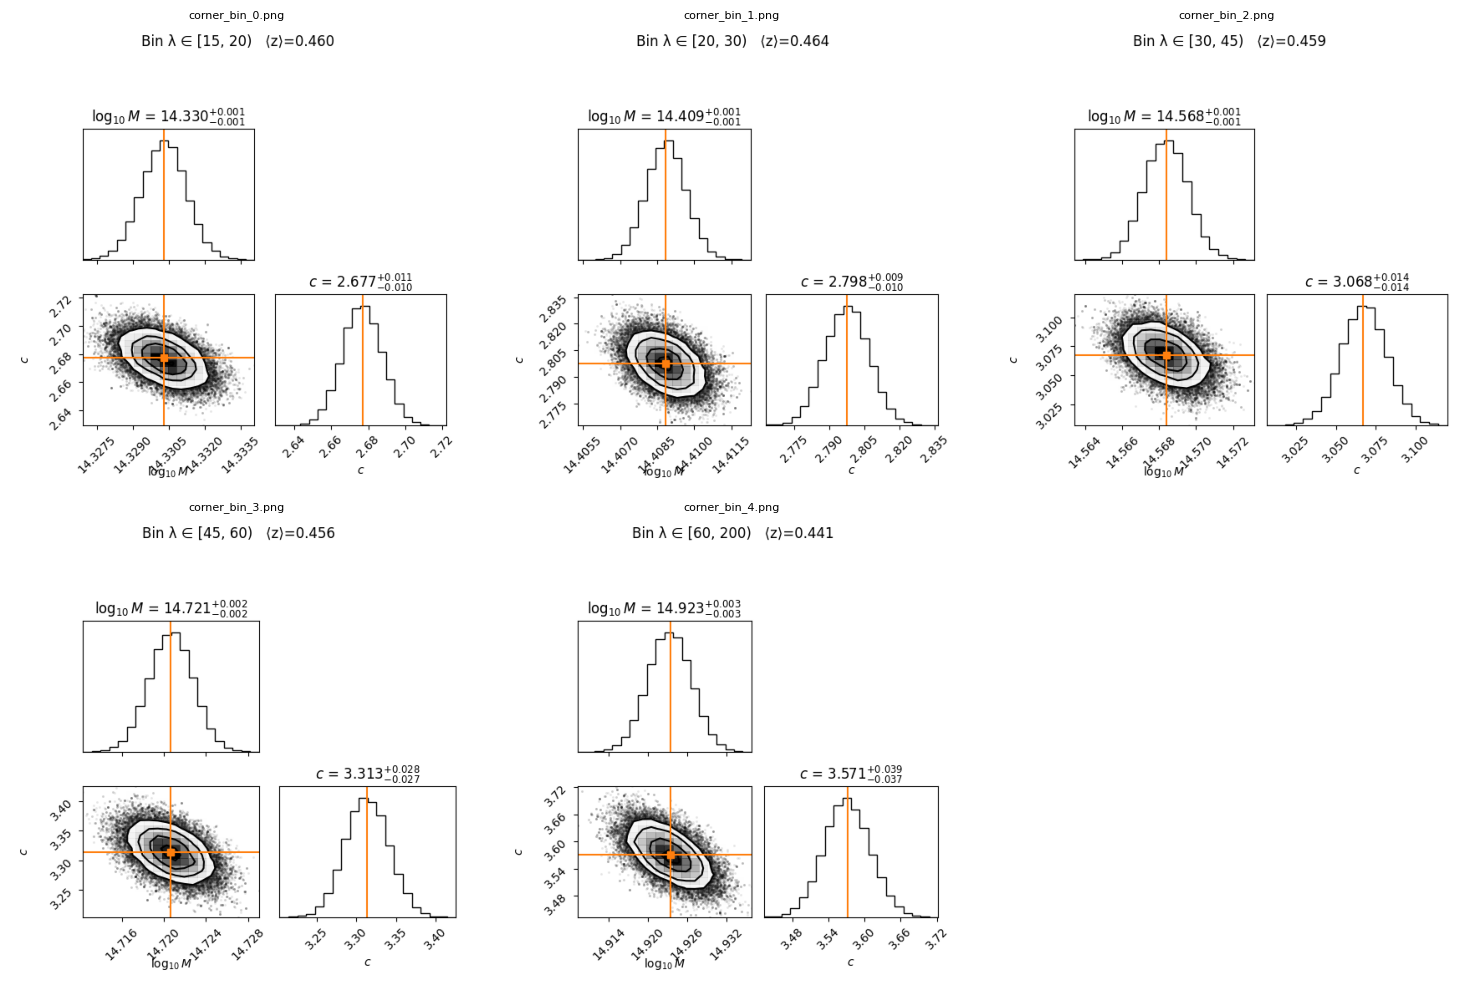

In [68]:
#plot dei grafici
import matplotlib.image as mpimg

files = ["corner_bin_0.png", "corner_bin_1.png", "corner_bin_2.png", "corner_bin_3.png", "corner_bin_4.png"]


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, fn in zip(axes, files):
    img = mpimg.imread(fn)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(fn, fontsize=8)


for ax in axes[len(files):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


### Confronto finale: profili simulati vs. modello NFW best-fit

Nell’ultimo grafico tracciamo, per ciascun bin di ricchezza λ:

1. **Punti con barre d’errore**  
   *Coordinate:* raggio $R_i$ (ascissa); profilo medio  
   $\langle\Sigma_{\text{sim}}(R_i)\rangle$ (ordinata).  
   *Errore verticale* = $\sigma_i $  
   

2. **Linea tratteggiata**: profilo NFW calcolato ai **parametri best-fit**  
   estratti dalla catena MCMC (massimo log-posterior):
   $$
     \bigl(\log_{10}M_{\star},\,c_{\star}\bigr)
     = \arg\max\!\bigl[\ln p(\log_{10}M, c \mid \text{dati})\bigr].
   $$


Il risultato visivo consente di verificare
quanto il profilo teorico descriva bene 
i dati raccolti dal file `halo_catalog.fit`.


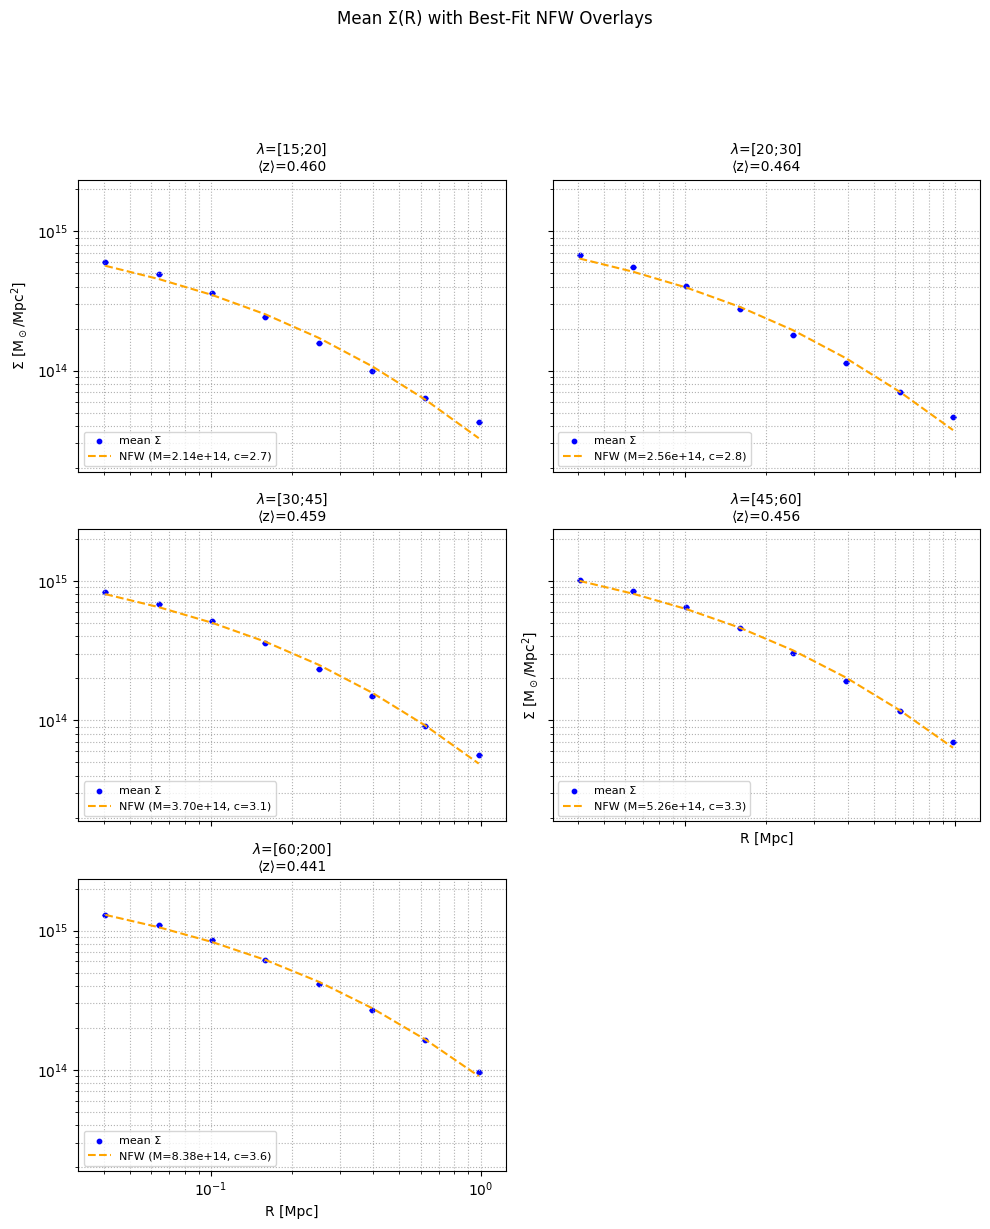

In [70]:

# plot finale con best fit
fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=True, sharey=True)
axes = axes.flatten()

fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes):
    if i >= len(mean_sigmas):
        ax.axis('off')
        continue

    # parametri dei files
    μ = mean_sigmas[i]
    σ = std_sigmas[i]/halo_counts[i]
    zbar = mean_z[i]
    ax.scatter(R, μ, s=10, color='blue', label="mean Σ")
    ax.errorbar(R, μ, yerr=σ, fmt='none', ecolor='blue', elinewidth=1, capsize=2, alpha=0.7)
    row = dfD.iloc[i]


    M_bf = 10**row["log10M_bf"]
    c_bf = row["c_bf"]

    # curva teorica
    Σ_bf = proj_nfw_sigma(R, M_bf, c_bf, z=zbar)
    ax.plot(
        R, Σ_bf, '--',
        color='orange',
        lw=1.5,
        label=rf"NFW (M={M_bf:.2e}, c={c_bf:.1f})"
    )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(x_lo, x_hi)
    ax.set_ylim(y_lo, y_hi)
    ax.grid(True, which='both', ls=':')
    ax.set_title(
        rf"$\lambda$=[{int(row['lambda_min'])};{int(row['lambda_max'])}]" 
        + "\n" + rf"⟨z⟩={row['z_mean']:.3f}",
        fontsize=10
    )
    if i % 3 == 0:
        ax.set_ylabel(r"$\Sigma$ [M$_\odot$/Mpc$^2$]")
    if i // 3 == 1:
        ax.set_xlabel("R [Mpc]")

    ax.legend(fontsize=8, loc='lower left')

fig.suptitle("Mean Σ(R) with Best-Fit NFW Overlays", y=1.02)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


### 5&nbsp;&nbsp;Conclusioni

Possiamo trarre le seguenti considerazioni:

1. **Buon accordo visivo tra modello e dati**  
   Il profilo NFW proiettato, ottimizzato sui parametri $ \log_{10}M $ e $ c $ per ciascun bin di ricchezza, riproduce con grande accuratezza la forma dei profili medi $ \Sigma(R) $. I diagrammi “corner” evidenziano distribuzioni a posteriori ristrette e curve che seguono fedelmente i valori misurati.

2. **$ \chi^2 $ sensibilmente superiore ai gradi di libertà**  
   Nonostante l’ampia corrispondenza visiva, i valori di $ \chi^2 $ calcolati nel punto di massima posterior si attestano molto al di sopra dei corrispondenti gradi di libertà. Ciò impone di rigettare l’ipotesi secondo cui un modello NFW puro, considerato insieme agli errori di misura, sia sufficiente a spiegare la dispersione dei dati.

3. **Modello incompleto e complessità della materia oscura**  
   Il valore di $ \chi^2 $ suggerisce che il profilo NFW, nella sua forma base, non tenga conto di effetti fisici reali quali:  
   - contributo della struttura a larga scala 2‑halo;  
   - mis‑centering e sotto‑strutture interne all’alone;  
   - boost factor dovuto a galassie satellite;  
   - scatter intrinseco della distribuzione di materia oscura.  
   Tali mancanze generano residui sistematici non descritti dagli errori statistici.

4. **Dipendenza dal bin di ricchezza $ \lambda $**  
   Si osserva un calo progressivo di $ \chi^2 $ all’aumentare della ricchezza (e quindi della massa media dell’alone). Questo indica che il profilo NFW risulta più aderente per aloni più massicci, coerentemente con le predizioni delle simulazioni su larga scala.

---
### Ipotesi di correzione

- **Completare il modello fisico con le seguenti aggiunte:**  
  - **Termine 2‑halo**: aggiungere il contributo della struttura a larga scala, dominante per $R \gtrsim 1$ Mpc, che si somma al profilo 1‑halo NFW.  
  - **Scatter intrinseco $s_{\mathrm{int}}$**: introdurre un parametro di varianza additiva che descriva le differenze dovute a storia di formazione e sub‑strutture non modellate, riducendo l’eccesso di residui a piccoli $R$.  
  - **Mis‑centratura**: convolvere il profilo con una distribuzione di offset (tipicamente Rayleigh) per tenere conto della distanza tra il centro “vero” dell’alone e il centro osservazionale.  
  - **Boost factor**: correggere il segnale di weak‑lensing per la contaminazione di galassie membro non rimosse.

- **Uso della covarianza completa**  
  Stimare l’intera matrice di covarianza (e non solo la diagonale) tramite resampling jackknife o bootstrap, così da includere le correlazioni radiali e ottenere pesi più realistici nella likelihood.

- **Approccio bayesiano ampliato**  
  Includere i parametri extra (2‑halo, mis‑centering, $s_{\mathrm{int}}$) direttamente nella catena MCMC e marginalizzare sulle loro incertezze, producendo posteriori più affidabili.

- **Analisi di dipendenze aggiuntive**  
  Indagare l’impatto di ambiente, redshift e proprietà delle galassie satellite sul fit, per comprendere come la validità del profilo NFW vari lungo queste dimensioni.

Se implementati, questi sviluppi ridurrebbero gli scarti sistematici e dovrebbero portare i valori di $ \chi^2 $ all’interno di un intervallo compatibile con le aspettative statistiche, fornendo al contempo una descrizione più completa e fisicamente motivata della distribuzione di materia oscura negli ammassi.

